### Lab 5 Overview
#### First Half
- Machine Learning
- Clustering with kmeans
- Regression Trees (continuous predictions with tree models)

#### Second Half
- *Questions?*

--------

### Machine Learning
https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf
- Generalize the model (train dataset will almost never be the same as "test" dataset, let alone real world test data)
    - Avoid overfitting
    - Remember the bias that can occur with a normal train-test split (80% train vs 20% test is not representitive and can change depending on the split)
    - Cross validation
- There is never enough data
    - Models will always make certain assumptions 
    - Even the best model may be no better than a DummyClassifier (random predictions). Think about real world problems with 25% accuracy such as NLP...
- Overfitting
    - Bias: a learner's tendency to consistently learn the wrong labels
    - Variance: tendency to learn random things irrespective of the true labels
    ![bv](./cloud/bv.PNG)
    - Consider bias on linear models. They rely on the data being linearly seperable by a hyperplane. But what if it is not...
    - Consier variance on tree models.  They can represent any boolean function to seperate the data, but can learn very different things depending on the training data
    - Can do cross validation or maybe a $\chi^2$ test (from statistics / lsm) during feature selection 
- Curse of dimensionality
    - As your feature space increases, the number of possible configurations grows exponentially, thus, the number of possible configurations covered by your observation decreases. 
    - Imagine a dataset with more features than observations
    - https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e
- Feature Engineering is Key
    - Why do models fail? Most likely due to the feature space used.
    - You will come to understand that all the time in ML is spent on preprocessing and feature engineering.
    - A simple model that is interpretable and utilises all the data is far more favourable than a complex model with cannot be interpreted easily with a subset of the data...
- Learn several models
    - Use a baseline to figure out the difficulty of your problem
    - Try a wide range of models (regression vs trees vs svm vs clustering) and analyse why some may do better than other
    - Think of techniques such as bagging, boosting, etc
        - Bagging: Generate random variations of the training set through resampling then use a set of classifiers in a voting system
        - Boosting: Training examples have weights which are varied so each new classifier aim to focus on the examples that previous classifiers failed 
- Correlation does not imply causation


----------------

### Clustering (Useful for lat/lon datasets)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
plt.style.use(['dark_background'])

from sklearn.cluster import KMeans
from IPython.display import Image

df = pd.read_csv("../Data/Lab4/100k_yellow_2015_05.csv").dropna()
df = df.loc[(df['pickup_latitude'] > 40.6) & (df['pickup_latitude'] < 40.9) & 
            (df['pickup_longitude'] < -73.6) & (df['pickup_longitude'] > -74.05)]
df = df.loc[(df['dropoff_latitude'] > 40.6) & (df['dropoff_latitude'] < 40.9) & 
            (df['dropoff_longitude'] < -73.6) & (df['dropoff_longitude'] > -74.05)]
df['cluster'] = -1

In [2]:
# create a datframe of just coordinates
df_coords = pd.DataFrame()
df_coords['lat'] = df['pickup_latitude']
df_coords['lon'] = df['pickup_longitude']

In [3]:
df_coords.sort_values(["lat","lon"])

,lat,lon
41988,40.600712,-73.950699
98932,40.602348,-73.993340
26856,40.608181,-73.961899
36097,40.610065,-73.962128
72225,40.610680,-73.962433
...,...,...
11764,40.870747,-73.846771
7735,40.874477,-73.910355
8490,40.878685,-73.904968
84796,40.879166,-73.837708


In [4]:
%%time
# run kmeans and output labels
K = 13

kmeans = KMeans(n_clusters=K).fit(df_coords)
df_coords['cluster'] = kmeans.labels_

CPU times: user 20.9 s, sys: 922 ms, total: 21.8 s
Wall time: 4.86 s


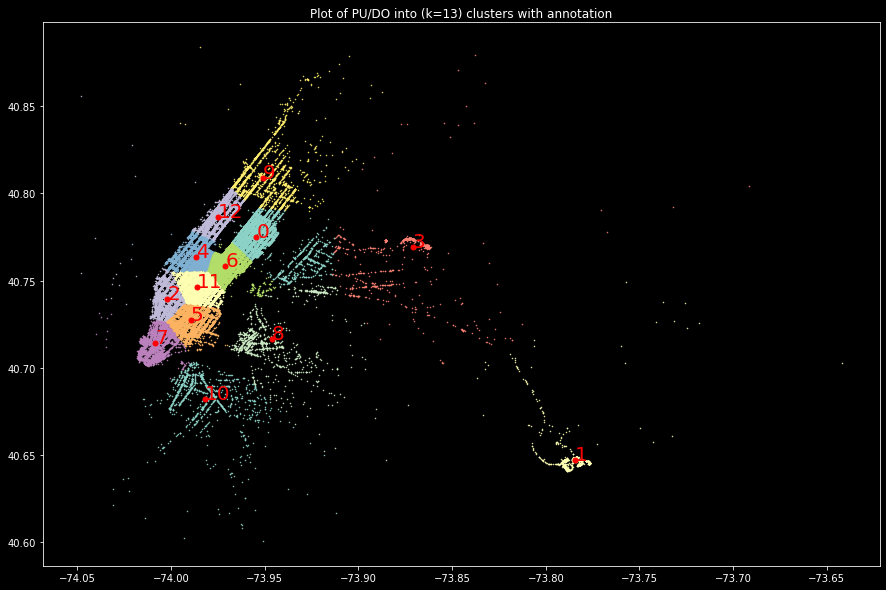

In [5]:
# sns.scatterplot(data=df_coords, x='lon',y='lat', size=10, hue='cluster')

fig, ax = plt.subplots(figsize = (15,10))

for cluster in range(K):
    cluster_coords = df_coords.loc[df_coords['cluster'] == cluster, ['lon','lat']]
    ax.plot(cluster_coords['lon'], cluster_coords['lat'], '.', markersize=1)
    center = kmeans.cluster_centers_[cluster]
    ax.plot(center[1], center[0], 'o', color='red', markersize=5)
    ax.annotate(cluster, (center[1], center[0]), color = 'red', fontsize = 20)
    
plt.title(f"Plot of PU/DO into (k={K}) clusters with annotation")
plt.savefig("../plots/cluster.jpg")

- Think about different values of `k`

Cool, we've added our cluster labels. Now, let's update our dataframe with the clusters.

Now, the normal way to do this would be a merge (equivalent of an SQL join - refer to database systems).  
As usual, there are better techniques to do this.

- We are assuming the index on `df` matches the index on `df_coords`
- `df.update()` is in-place

Tests:

```python
%%time
df.merge(df_coords, left_on=df.index, right_on=df_coords.index).drop("key_0",axis=1)

>>> CPU times: user 78.1 ms, sys: 31.2 ms, total: 109 ms
>>> Wall time: 98.5 ms
    
%%time
df.update(df_coords)

>>> CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
>>> Wall time: 26 ms
```

In [6]:
%%time
df.update(df_coords)

CPU times: user 141 ms, sys: 31.2 ms, total: 172 ms
Wall time: 40.6 ms


In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,cluster
0,1,2015-05-05 23:37:40,2015-05-05 23:45:41,1,2.00,-74.001678,40.739311,1,N,-73.978294,40.752110,2,8.5,0.5,0.5,0.00,0.0,0.3,9.80,2
1,2,2015-05-05 23:37:40,2015-05-05 23:40:36,1,0.54,-73.930840,40.744789,1,N,-73.937515,40.749359,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,8
2,2,2015-05-05 23:37:40,2015-05-05 23:44:03,3,2.10,-74.001411,40.731087,1,N,-73.981674,40.758282,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30,2
3,2,2015-05-05 23:37:40,2015-05-06 00:14:01,6,10.93,-73.970673,40.758560,1,N,-73.933762,40.670544,1,36.0,0.5,0.5,9.32,0.0,0.3,46.62,6
4,2,2015-05-05 23:37:40,2015-05-05 23:46:03,5,0.93,-73.986732,40.755878,1,N,-73.990959,40.749981,1,7.0,0.5,0.5,2.49,0.0,0.3,10.79,4


(From the lab): Suppose now we want to construct a regression tree using the `tolls_amount` as response, and `cluster`,`trip_distance`,`passenger_count` as predictors.

### Regression Tree
- Can make continuous predictions (rather than classifications like Decision Trees)

In [8]:
from sklearn import tree

y = df['tolls_amount']
X = df[['cluster','trip_distance']]

In [9]:
# default params
reg = tree.DecisionTreeRegressor(max_depth=2)
reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Let's see what the tree looks like...
- `sudo apt-get install graphviz`
- `pip3 install graphviz`
- https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft
- https://graphviz.org/download/

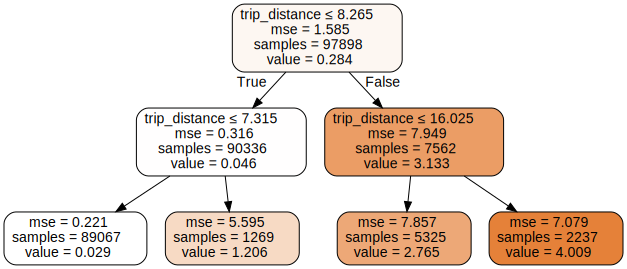

In [10]:
import graphviz 

tree.export_graphviz(reg, out_file='pruned.dot', feature_names=X.columns,
                     filled=True, rounded=True, special_characters=True)

with open("./pruned.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

The plot shows predictions of `tolls_amount` under different conditions. For example:
- If a passenger travels between `7.315`km and `8.265`km, then they are expected to pay `~$1.206` on average
- If a passenger travels `<=7.315`km, then they are expected to pay `~$0.029` on average
- If a passenger travels between `8.265`km and `16.025`km, then they are expected to pay `~$2.765` on average
- If a passenger travels `>16.025`km, then they are expected to pay `~$4.009` on average
- Overall, the longer a passenger travels, the more they will pay for tolls on average

### KNN 
- A non-parametric classificator
- https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/ (parametric vs non-parametric)

(From the lab): Suppose we want to find a customer whose travel distance (between two clusters) is `5` or `2`.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

y = df['cluster'].values
X = [[i] for i in df['trip_distance'].values]

knn_distance = KNeighborsClassifier(n_neighbors=20)
knn_distance.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

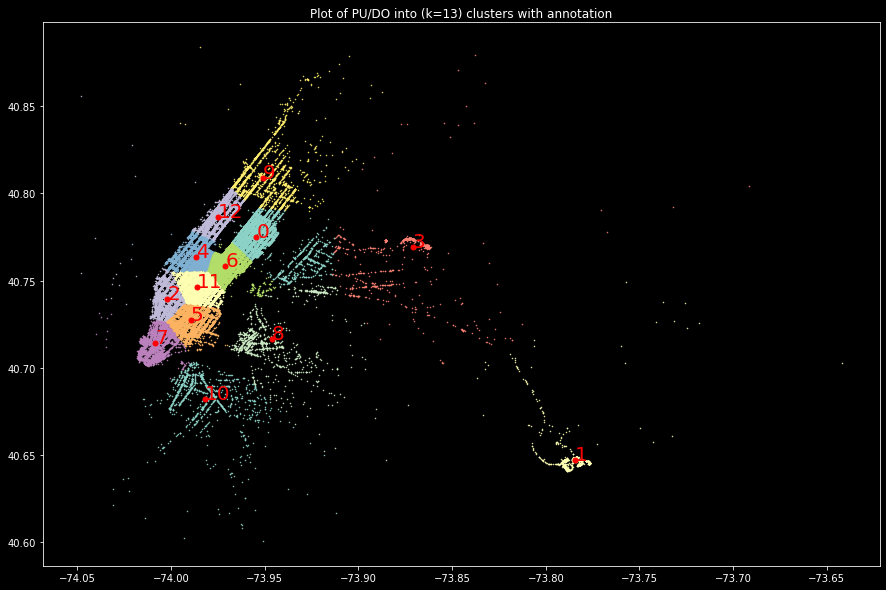

In [12]:
fig

In [13]:
X_predict = [[5],[2]] # trip_distance = 5, trip_distance = 2
results = knn_distance.predict(X_predict)

for pred, result in zip(X_predict, results):
    print(f'Cluster [{result}] will be the best cluster for taxi drivers looking to find passengers who travel {pred} miles "out"')

Cluster [11] will be the best cluster for taxi drivers looking to find passengers who travel [5] miles "out"
Cluster [2] will be the best cluster for taxi drivers looking to find passengers who travel [2] miles "out"


Let's keep going...  

How about if we want trips that give tip amounts of `$3.2` or `$0.1` respectively?
- Filter based on the `payment_type == 1` first

In [14]:
filtered = df.loc[df['payment_type'] == 1]
y = filtered['cluster'].values
X = [[i] for i in filtered['trip_distance'].values]

knn_tips = KNeighborsClassifier(n_neighbors=20)
knn_tips.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

In [15]:
X_predict = [[3.2],[0.1]] # tip_amounts = 3.2, tip_amounts = 0.1
knn_tips.predict(X_predict)

print("(Assuming card payments)")
for pred, result in zip(X_predict, results):
    print(f'Cluster [{result}] presents the best chance of getting ${pred[0]} in tips')
    
print(f"\n*or cluster [{result}] might have lower number of people who pay by card... who knows?*")

(Assuming card payments)
Cluster [11] presents the best chance of getting $3.2 in tips
Cluster [2] presents the best chance of getting $0.1 in tips

*or cluster [2] might have lower number of people who pay by card... who knows?*


How about we combine both `trip_distance` and `tip_amount`?

In [16]:
y = filtered['cluster'].values
X = filtered[['trip_distance','tip_amount']].values

the_knn = KNeighborsClassifier(n_neighbors=20)

the_knn.fit(X, y)

KNeighborsClassifier(n_neighbors=20)

Let's try predicting the best cluster which will give us:
- `8`miles with `$2.4` tips (medium distance low tips)
- `1`miles with `$4.2` tips (short distance high tips)

In [17]:
X_predict = [[8, 2.4], [1,4.2]] 
the_knn.predict(X_predict )

print("(Assuming card payments)")
for pred, result in zip(X_predict, results):
    print(f'Cluster [{result}] presents the best chance of getting a trip that goes for {pred[0]} miles with ${pred[1]} tips')

(Assuming card payments)
Cluster [11] presents the best chance of getting a trip that goes for 8 miles with $2.4 tips
Cluster [2] presents the best chance of getting a trip that goes for 1 miles with $4.2 tips


(From the lab): **Now you may try to explore a little bit more using a larger data set, and start
to work on your second assignment. Good luck.**